# Libraries and Helper Functions

In [1]:
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation

In [2]:
def model_evaluation(X, y, model, label):
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    print('{0} Accuracy: {1:.4f}'.format(label, accuracy))
    cm = confusion_matrix(y, predictions)
    cm = cm.astype('float') / cm.sum(axis=1)
    df_cm = pd.DataFrame(cm, index = sorted(y.unique()), columns = sorted(y.unique()))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
def get_feature_importance(model, X_train):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    feature_importance = [feature_importance[i] for i in indices]
    predictors = X_train.columns
    predictors = [predictors[i] for i in indices]
    predictors_index = range(1, len(predictors) + 1)
    num_features = X_train.shape[1]
    #num_features = len(predictors) if num_features is None else num_features
    plt.figure(figsize=(20,20))
    plt.bar(predictors_index[:num_features], feature_importance[:num_features], align = 'center')
    plt.xticks(predictors_index[:num_features], predictors[:num_features], rotation = 'vertical')
    plt.show()

In [4]:
# load and clean data
train_df = pd.read_csv('train_w_cluster.csv')
test_df = pd.read_csv('test_w_cluster.csv')
train_df['vote_count'] = train_df['vote_count'].apply(lambda x: int(x.replace('[', '').replace(']', '')))

In [5]:
# create dummy columns and remove string variables
columns_to_remove = ['overview', 'tagline', 'plot', 'plot outline', 'mpaa_rating_text', 'id']
dummy_columns = ['mpaa_rating', 'overview_cluster', 'tagline_cluster', 'plot_cluster', 'plot outline_cluster', 'mpaa_rating_text_cluster']
for column in dummy_columns:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[column], prefix = column, prefix_sep = '_')], axis=1)
    test_df = pd.concat([test_df, pd.get_dummies(test_df[column], prefix = column, prefix_sep = '_')], axis=1)
train_df = train_df.drop(columns_to_remove + dummy_columns, axis = 1)
test_df = test_df.drop(columns_to_remove + dummy_columns, axis = 1)

In [6]:
test_df.head(5)

,part_of_collection,budget,popularity,production_companies,release_month,release_year,revenue,runtime,spoken_languages,vote_average,...,mpaa_rating_text_cluster_0,mpaa_rating_text_cluster_1,mpaa_rating_text_cluster_2,mpaa_rating_text_cluster_3,mpaa_rating_text_cluster_4,mpaa_rating_text_cluster_5,mpaa_rating_text_cluster_6,mpaa_rating_text_cluster_7,mpaa_rating_text_cluster_8,mpaa_rating_text_cluster_9
0,False,0,0.188719,0,9,2006,0,132.0,1,7.2,...,0,0,1,0,0,0,0,0,0,0
1,True,4000000,0.696750,2,11,1981,125728258,94.0,1,6.1,...,0,0,1,0,0,0,0,0,0,0
2,False,0,0.157579,1,4,1995,0,105.0,1,7.0,...,0,0,1,0,0,0,0,0,0,0
3,False,0,0.162032,2,3,1996,0,135.0,1,5.5,...,0,0,1,0,0,0,0,0,0,0
4,False,48000000,1.556948,5,12,2000,207515725,148.0,2,6.9,...,0,0,1,0,0,0,0,0,0,0


In [7]:
print(train_df.shape)
print(test_df.shape)

(9208, 75)
(3947, 75)


In [8]:
X_train = train_df.drop('genre', axis = 1).head(100)
y_train = train_df['genre'].head(100)
X_test = test_df.drop('genre', axis = 1).head(100)
y_test = test_df['genre'].head(100)

# Use All Features

### Default Param Model

Train Accuracy: 1.0000


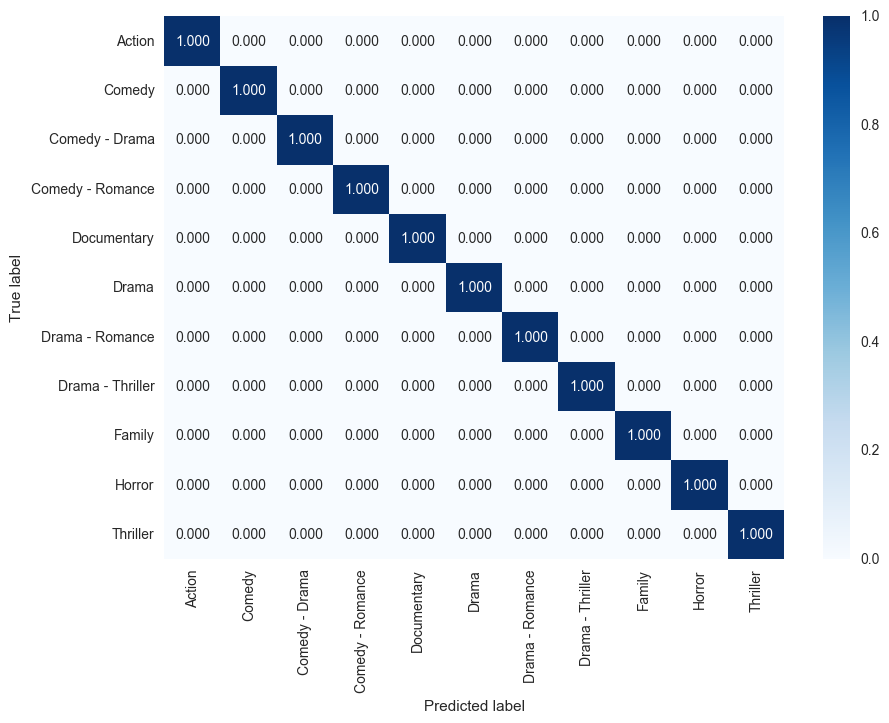

In [9]:
base_model = XGBClassifier()
base_model.fit(X_train, y_train)
model_evaluation(X_train, y_train, base_model, 'Train')

### First Tune max_depth and min_child_weight

In [10]:
# parameter definitions
'''
max_depth : int
Maximum tree depth for base learners.
learning_rate : float
Boosting learning rate (xgb’s “eta”)
n_estimators : int
Number of boosted trees to fit.
silent : boolean
Whether to print messages while running boosting.
objective : string or callable
Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).
nthread : int
Number of parallel threads used to run xgboost.
gamma : float
Minimum loss reduction required to make a further partition on a leaf node of the tree.
min_child_weight : int
Minimum sum of instance weight(hessian) needed in a child.
max_delta_step : int
Maximum delta step we allow each tree’s weight estimation to be.
subsample : float
Subsample ratio of the training instance.
colsample_bytree : float
Subsample ratio of columns when constructing each tree.
colsample_bylevel : float
Subsample ratio of columns for each split, in each level.
reg_alpha : float (xgb’s alpha)
L1 regularization term on weights
reg_lambda : float (xgb’s lambda)
L2 regularization term on weights
scale_pos_weight : float
Balancing of positive and negative weights.
base_score:
The initial prediction score of all instances, global bias.
seed : int
Random number seed.
'''
model_a = XGBClassifier()
XGB_PARAMETERS = {'max_depth': range(3,10,2), 'min_child_weight': range(0,6,2)}
model_a_cv = GridSearchCV(model_a, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
model_a_cv.fit(X_train, y_train)

/Users/tyler/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/tyler/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tyler/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [0, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=0)

In [11]:
model_a_cv.grid_scores_, model_a_cv.best_params_, model_a_cv.best_score_

([mean: 0.21064, std: 0.12225, params: {'max_depth': 3, 'min_child_weight': 0},
  mean: 0.22126, std: 0.07236, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.16396, std: 0.07527, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.20543, std: 0.10277, params: {'max_depth': 5, 'min_child_weight': 0},
  mean: 0.20348, std: 0.06546, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.18407, std: 0.09112, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.19497, std: 0.09964, params: {'max_depth': 7, 'min_child_weight': 0},
  mean: 0.19255, std: 0.05869, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: 0.18407, std: 0.09112, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.17543, std: 0.07660, params: {'max_depth': 9, 'min_child_weight': 0},
  mean: 0.19255, std: 0.05869, params: {'max_depth': 9, 'min_child_weight': 2},
  mean: 0.18407, std: 0.09112, params: {'max_depth': 9, 'min_child_weight': 4}],
 {'max_depth': 3, 'min_child_weight': 2

### Second: Tune gamma

In [12]:
model_b = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in model_a_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'gamma': [i/10.0 for i in range(0,5)]})
print XGB_PARAMETERS
model_b_cv = GridSearchCV(model_b, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
model_b_cv.fit(X_train, y_train)
model_b_cv.grid_scores_, model_b_cv.best_params_, model_b_cv.best_score_

{'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'max_depth': [3], 'min_child_weight': [2]}


([mean: 0.22126, std: 0.07236, params: {'max_depth': 3, 'gamma': 0.0, 'min_child_weight': 2},
  mean: 0.21552, std: 0.06078, params: {'max_depth': 3, 'gamma': 0.1, 'min_child_weight': 2},
  mean: 0.20345, std: 0.07195, params: {'max_depth': 3, 'gamma': 0.2, 'min_child_weight': 2},
  mean: 0.19133, std: 0.06232, params: {'max_depth': 3, 'gamma': 0.3, 'min_child_weight': 2},
  mean: 0.20718, std: 0.06877, params: {'max_depth': 3, 'gamma': 0.4, 'min_child_weight': 2}],
 {'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 2},
 0.22125744843391906)

### Third: Tune subsample and colsample_bytree

In [13]:
print 2+2
model_c = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in model_b_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'subsample':[i/10.0 for i in range(6,10)],
                       'colsample_bytree':[i/10.0 for i in range(6,10)]})
model_c_cv = GridSearchCV(model_c, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
model_c_cv.fit(X_train, y_train)
model_c_cv.grid_scores_, model_c_cv.best_params_, model_c_cv.best_score_

4


([mean: 0.20038, std: 0.09461, params: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 3, 'gamma': 0.0, 'min_child_weight': 2},
  mean: 0.18383, std: 0.10021, params: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 3, 'gamma': 0.0, 'min_child_weight': 2},
  mean: 0.20893, std: 0.08063, params: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 3, 'gamma': 0.0, 'min_child_weight': 2},
  mean: 0.19844, std: 0.10931, params: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 3, 'gamma': 0.0, 'min_child_weight': 2},
  mean: 0.21240, std: 0.08294, params: {'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 3, 'gamma': 0.0, 'min_child_weight': 2},
  mean: 0.20133, std: 0.06273, params: {'subsample': 0.7, 'colsample_bytree': 0.7, 'max_depth': 3, 'gamma': 0.0, 'min_child_weight': 2},
  mean: 0.17801, std: 0.06321, params: {'subsample': 0.8, 'colsample_bytree': 0.7, 'max_depth': 3, 'gamma': 0.0, 'min_child_weight': 2},
  mean: 0.18549, std: 0.10386, params: {'

In [14]:
model_d = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in model_c_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'reg_alpha':[1e-5, 1e-3, 0.1, 1, 10, 100]})
model_d_cv = GridSearchCV(model_d, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
model_d_cv.fit(X_train, y_train)
model_d_cv.grid_scores_, model_d_cv.best_params_, model_d_cv.best_score_

([mean: 0.21920, std: 0.12228, params: {'reg_alpha': 1e-05, 'colsample_bytree': 0.9, 'min_child_weight': 2, 'subsample': 0.6, 'max_depth': 3, 'gamma': 0.0},
  mean: 0.21864, std: 0.12074, params: {'reg_alpha': 0.001, 'colsample_bytree': 0.9, 'min_child_weight': 2, 'subsample': 0.6, 'max_depth': 3, 'gamma': 0.0},
  mean: 0.21756, std: 0.12069, params: {'reg_alpha': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 2, 'subsample': 0.6, 'max_depth': 3, 'gamma': 0.0},
  mean: 0.16887, std: 0.06952, params: {'reg_alpha': 1, 'colsample_bytree': 0.9, 'min_child_weight': 2, 'subsample': 0.6, 'max_depth': 3, 'gamma': 0.0},
  mean: 0.13228, std: 0.06182, params: {'reg_alpha': 10, 'colsample_bytree': 0.9, 'min_child_weight': 2, 'subsample': 0.6, 'max_depth': 3, 'gamma': 0.0},
  mean: 0.03952, std: 0.00867, params: {'reg_alpha': 100, 'colsample_bytree': 0.9, 'min_child_weight': 2, 'subsample': 0.6, 'max_depth': 3, 'gamma': 0.0}],
 {'colsample_bytree': 0.9,
  'gamma': 0.0,
  'max_depth': 3,
  'min_

In [15]:
model_e = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in model_d_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'learning_rate':[0.1], 'n_estimators':[5000]})
model_e_cv = GridSearchCV(model_d, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
model_e_cv.fit(X_train, y_train)
model_e_cv.grid_scores_, model_e_cv.best_params_, model_e_cv.best_score_

([mean: 0.18756, std: 0.07719, params: {'reg_alpha': 1e-05, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 2, 'n_estimators': 5000, 'subsample': 0.6, 'max_depth': 3, 'gamma': 0.0}],
 {'colsample_bytree': 0.9,
  'gamma': 0.0,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 2,
  'n_estimators': 5000,
  'reg_alpha': 1e-05,
  'subsample': 0.6},
 0.18755952380952379)

In [16]:
model_e.fit(X_train, y_train)
model_evaluation(X_train, y_train, model_e, 'Test')

XGBoostError: need to call fit beforehand

In [ ]:
### Fourth: Tune regularization params

In [ ]:
### Fifth: Reduce Learning Rate, Add More Tree

### Evaluate Model

Train Accuracy: 1.0000


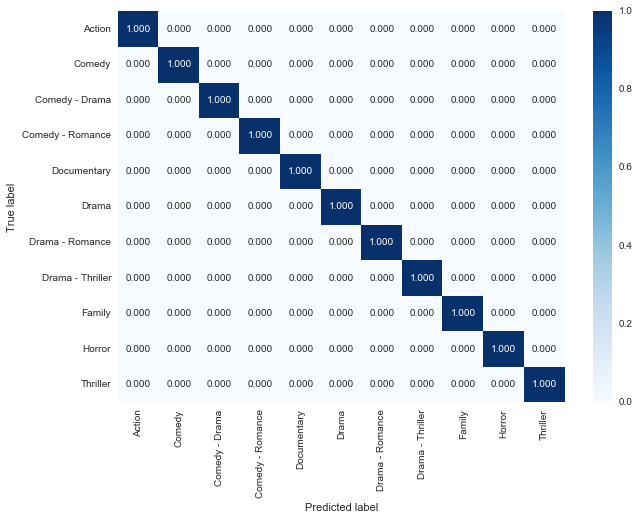

Test Accuracy: 0.4284


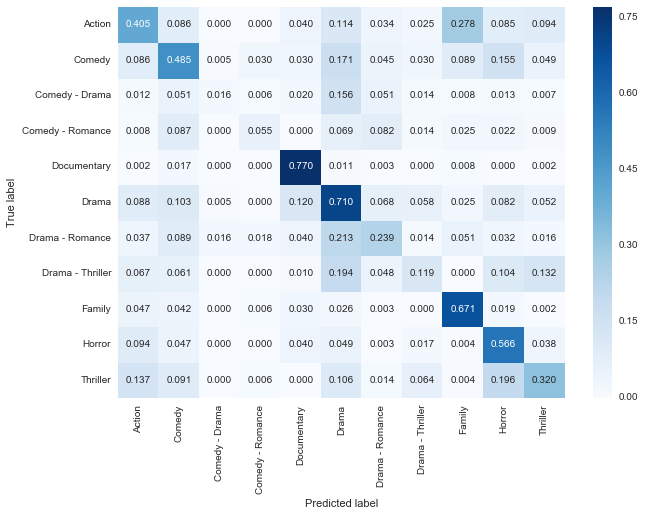

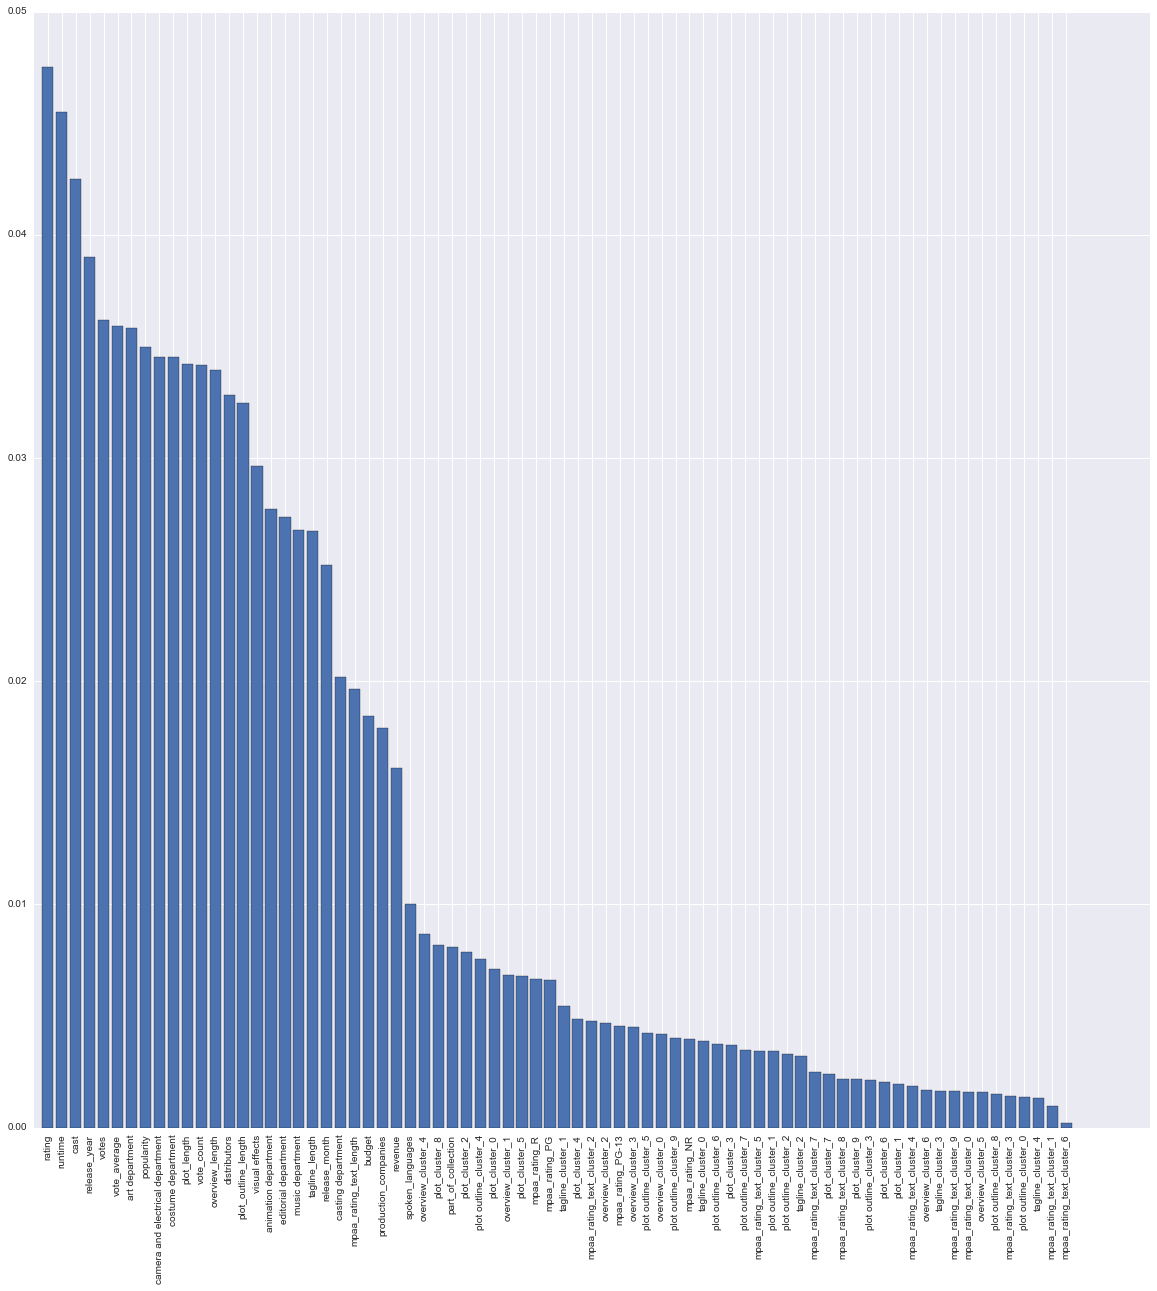

In [135]:
model_evaluation(X_train, y_train, model_e_cv.best_estimator_, 'Train')
model_evaluation(X_test, y_test, model_e_cv.best_estimator_, 'Test')
get_feature_importance(model_cv.best_estimator_, X_train)

# Exclude Rating / Clustering

In [137]:
columns_to_include = [column for column in X_train.columns if 'cluster' not in column and 'mpaa_rating' not in column]
X_train_1 = X_train[columns_to_include]
X_test_1 = X_test[columns_to_include]

### Tune Model

In [138]:
model = RandomForestClassifier()
model_cv = GridSearchCV(model, RF_PARAMETERS, scoring = "f1", cv = 5)
model_cv.fit(X_train_1, y_train)

C:\Users\Ihsaan Patel\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\Ihsaan Patel\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
 

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500], 'max_features': ['auto', 'sqrt', 'log2'], 'class_weight': [None, 'balanced', 'balanced_subsample'], 'random_state': [42], 'min_samples_leaf': [1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

### Evaluate Model

Train Accuracy: 1.0000


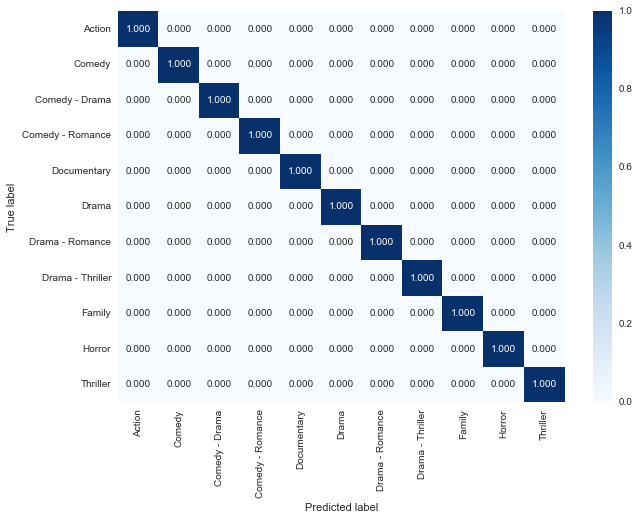

Test Accuracy: 0.3793


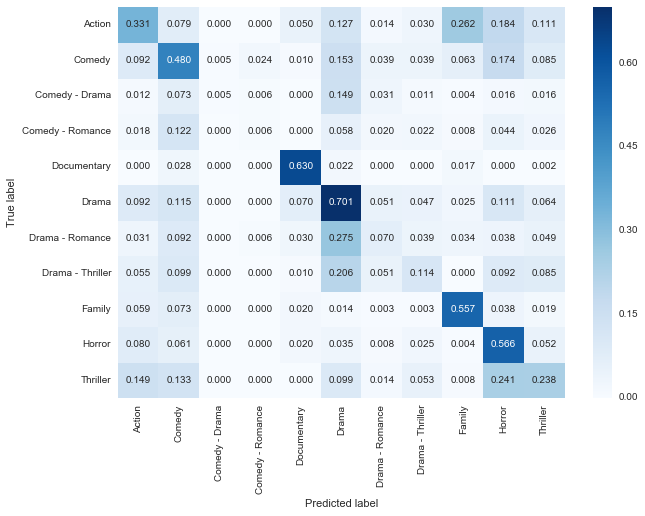

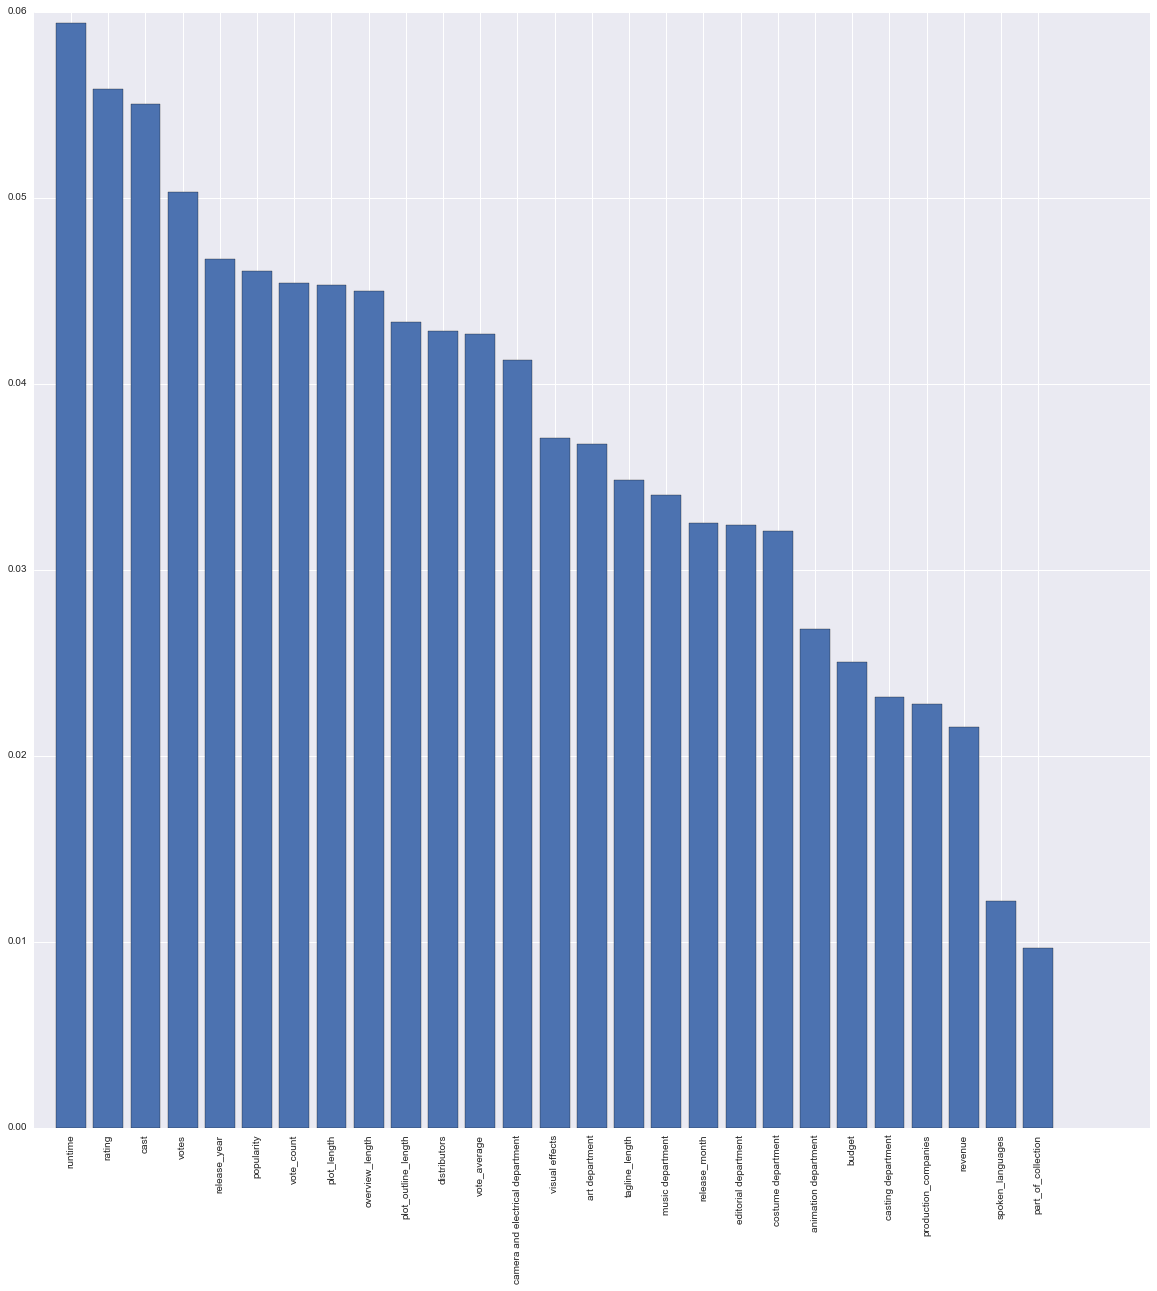

In [139]:
model_evaluation(X_train_1, y_train, model_cv.best_estimator_, 'Train')
model_evaluation(X_test_1, y_test, model_cv.best_estimator_, 'Test')
get_feature_importance(model_cv.best_estimator_, X_train_1)